## Introduction



In [6]:
!pip install prophet
import pyspark.sql.functions as F
from pyspark.sql.types import *

# specify the stock symbol to analyze - WHO, WHAT, IDK, WHY, BCUZ, TMRW, TDY, IDGD
# stock_symbols = ['CSCO', 'ADSK', 'INTC', 'ADBE', 'WMT', 'NFLX', 'DIS' , 'KO', 'AMZN', 'META']

# recommended: CSCO, WMT, KO

# STOCK_SYMBOL = "KO"
# STOCK_SYMBOL = "WMT"
STOCK_SYMBOL = "CSCO"

StatementMeta(, e58fbfc4-8412-4b0b-9b85-bdec62715a42, 8, Finished, Available)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 71.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.7/93.7 kB 49.9 MB/s eta 0:00:00


## Step 1: Download the stock history source data files


In [30]:
import os
import datetime
from datetime import timedelta

LAKEHOUSE_FOLDER = "/lakehouse/default"
DATA_FOLDER = "Files/data"
RTA_FOLDER = "Files/fact_realtimestockdata"


TAR_FILE_PATH = f"/{LAKEHOUSE_FOLDER}/{DATA_FOLDER}/tar/"
CSV_FILE_PATH = f"/{LAKEHOUSE_FOLDER}/{DATA_FOLDER}/csv/"


StatementMeta(, e58fbfc4-8412-4b0b-9b85-bdec62715a42, 34, Finished, Available)

In [36]:
# read the CSV files, {year}/{month}/{day}.csv
df = spark.sql("SELECT price , symbol , timestamp FROM fact_realtimestockdata LIMIT 10")
display(df)

StatementMeta(, e58fbfc4-8412-4b0b-9b85-bdec62715a42, 40, Finished, Available)

SynapseWidget(Synapse.DataFrame, f8879dea-02b8-417b-b4b5-ff78524350c1)

## Step 2: Read the Parquet files into a DataFrame

In [37]:
# read the CSV files, {year}/{month}/{day}.csv

df_stocks = (
    spark.read.format("parquet")
    .load(f"{DATA_FOLDER}/stockhistory4/")
).union(df)

df_stocks.tail(8)

StatementMeta(, e58fbfc4-8412-4b0b-9b85-bdec62715a42, 41, Finished, Available)

[Row(price=950.83, symbol='INTC', timestamp='2024-03-19 23:20:22.435887'),
 Row(price=688.83, symbol='ADBE', timestamp='2024-03-19 23:20:22.435887'),
 Row(price=851.07, symbol='WMT', timestamp='2024-03-19 23:20:22.435887'),
 Row(price=895.52, symbol='NFLX', timestamp='2024-03-19 23:20:22.435887'),
 Row(price=864.05, symbol='DIS', timestamp='2024-03-19 23:20:22.435887'),
 Row(price=1014.84, symbol='AMZN', timestamp='2024-03-19 23:20:22.435887'),
 Row(price=851.63, symbol='KO', timestamp='2024-03-19 23:20:22.435887'),
 Row(price=904.62, symbol='META', timestamp='2024-03-19 23:20:22.435887')]

In [38]:
# remove all but specified stock symbol
# individual models can be built for each stock

df_stocks = df_stocks.select("*").where(
    f'symbol == "{STOCK_SYMBOL}"'
)

df_stocks.tail(4)

StatementMeta(, e58fbfc4-8412-4b0b-9b85-bdec62715a42, 42, Finished, Available)

[Row(price=972.71, symbol='CSCO', timestamp='2024-02-11 22:53:00'),
 Row(price=971.13, symbol='CSCO', timestamp='2024-02-11 22:54:00'),
 Row(price=960.86, symbol='CSCO', timestamp='2024-02-11 22:55:00'),
 Row(price=898.26, symbol='CSCO', timestamp='2024-03-19 23:20:22.435887')]

In [39]:
# strictly speaking, we don't need to sort the dataframe, 
# but it can help for exploration of the data 

df_stocks = df_stocks.sort("timestamp")
df_stocks.tail(4)

StatementMeta(, e58fbfc4-8412-4b0b-9b85-bdec62715a42, 43, Finished, Available)

[Row(price=965.45, symbol='CSCO', timestamp='2024-03-19 23:56:00'),
 Row(price=959.3, symbol='CSCO', timestamp='2024-03-19 23:57:00'),
 Row(price=960.9, symbol='CSCO', timestamp='2024-03-19 23:58:00'),
 Row(price=978.75, symbol='CSCO', timestamp='2024-03-19 23:59:00')]

In [40]:
# include only historical data when building model

import datetime

currentdate = datetime.datetime.utcnow()
currentdate = currentdate.replace(hour=0, minute=0, second=0, microsecond=0)

# to manually specify a cutoff date in the data, specify the date below:
# currentdate = "2023-11-27 00:00:00"

df_stocks_history = df_stocks.select("*").where(
    f'timestamp < "{str(currentdate)}"')

df_stocks_history.tail(4)

StatementMeta(, e58fbfc4-8412-4b0b-9b85-bdec62715a42, 44, Finished, Available)

[Row(price=884.57, symbol='CSCO', timestamp='2024-03-18 23:56:00'),
 Row(price=866.33, symbol='CSCO', timestamp='2024-03-18 23:57:00'),
 Row(price=851.87, symbol='CSCO', timestamp='2024-03-18 23:58:00'),
 Row(price=844.74, symbol='CSCO', timestamp='2024-03-18 23:59:00')]

In [41]:
# convert to a pandas dataframe, and rename the columns to 'ds' and 'y'  
# for time and label/outcome columns

import pandas as pd

dfstocks_pd = df_stocks_history.toPandas()

# rename the columns as expected by Prophet (ds and y)
dfstocks_pd = dfstocks_pd.rename(columns={'timestamp': 'ds'})
dfstocks_pd = dfstocks_pd.rename(columns={'price': 'y'})

# verify max/min timestamps in the dataframe, as the tail/head data may not be in order
print('Min: ', dfstocks_pd['ds'].min())
print('Max: ', dfstocks_pd['ds'].max())

StatementMeta(, e58fbfc4-8412-4b0b-9b85-bdec62715a42, 45, Finished, Available)

Min:  2024-01-01 00:00:00
Max:  2024-03-18 23:59:00


## Step 3: Train the model
In developing a model, we'll use [Prophet](https://facebook.github.io/prophet/) developed by Facebook's Core Data Science team. Prophet is ideal for forecasting time series data. Prophet excels at simplicity, so this is an ideal starting point as it limits any feature engineering and variables. 

In [42]:
# Prophet variables

changepoint_prior_scale = 0.05
changepoint_range = 0.95
seasonality_prior_scale = 10
weekly_seasonality = 5

StatementMeta(, e58fbfc4-8412-4b0b-9b85-bdec62715a42, 46, Finished, Available)

StatementMeta(, e58fbfc4-8412-4b0b-9b85-bdec62715a42, 47, Finished, Available)

Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
input tempfile: /tmp/tmpksxnogfi/ewz7qcla.json
input tempfile: /tmp/tmpksxnogfi/ycjrytv0.json
idx 0
running CmdStan, num_threads: None
CmdStan args: ['/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66163', 'data', 'file=/tmp/tmpksxnogfi/ewz7qcla.json', 'init=/tmp/tmpksxnogfi/ycjrytv0.json', 'output', 'file=/tmp/tmpksxnogfi/prophet_modelagjx307u/prophet_model-20240319235915.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
Chain [1] start processing
Chain [1] done processing


23:59:15 - cmdstanpy - INFO - Chain [1] start processing
00:00:34 - cmdstanpy - INFO - Chain [1] done processing


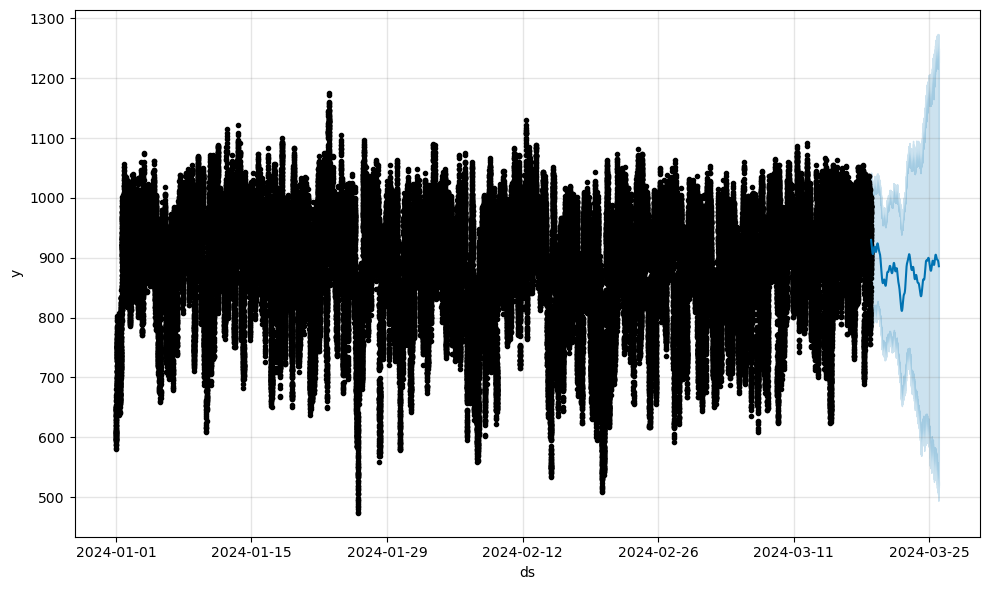

In [43]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

m = Prophet(changepoint_prior_scale = changepoint_prior_scale, 
    changepoint_range = changepoint_range, 
    seasonality_prior_scale = seasonality_prior_scale,
    weekly_seasonality=weekly_seasonality)
m.fit(dfstocks_pd)
future = m.make_future_dataframe(periods=60*24*7, freq='min', include_history = False)
forecast = m.predict(future)
fig = m.plot(forecast)

StatementMeta(, e58fbfc4-8412-4b0b-9b85-bdec62715a42, 48, Finished, Available)

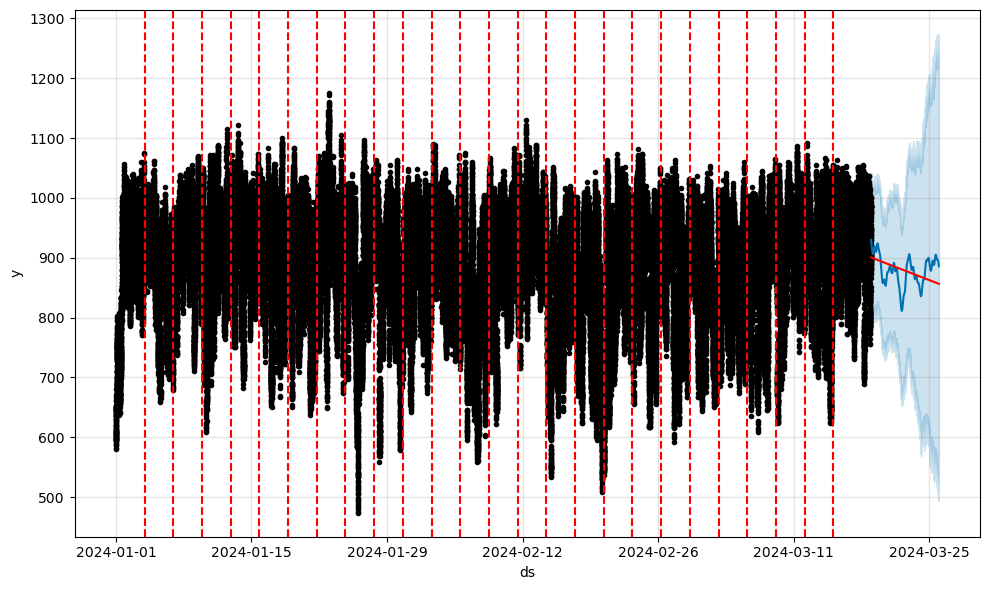

In [44]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

StatementMeta(, e58fbfc4-8412-4b0b-9b85-bdec62715a42, 49, Finished, Available)

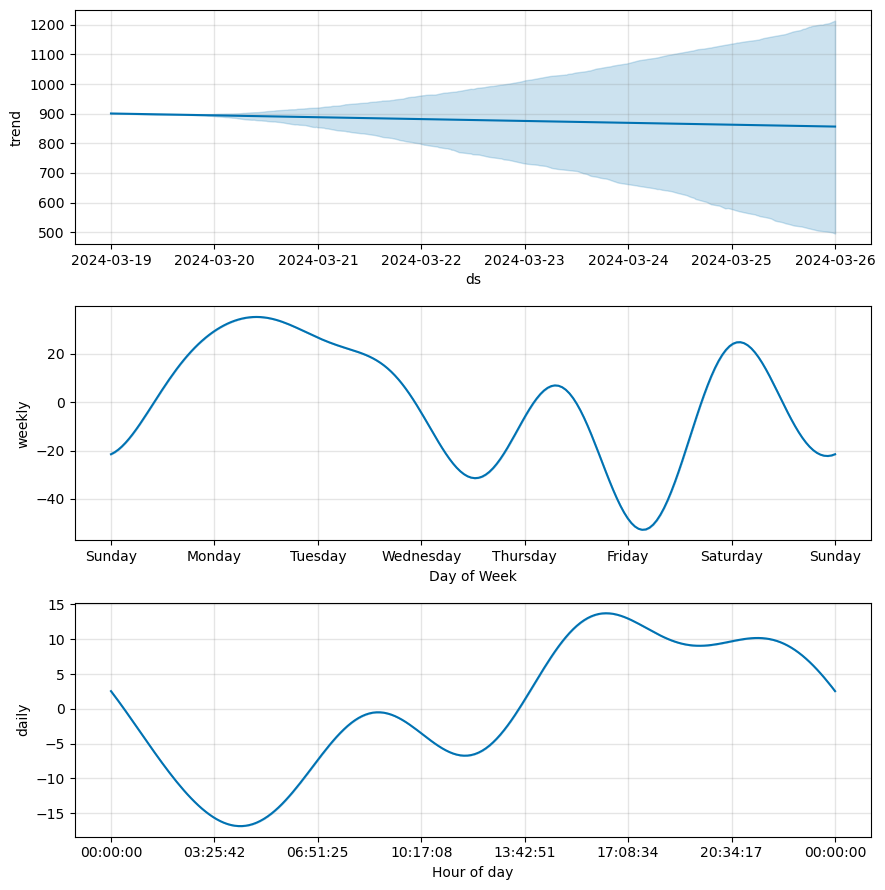

In [45]:
fig2 = m.plot_components(forecast)

In [46]:
# show the first few rows of the forecast
# yhat is predicted value of y at the given ds

forecast.head()

StatementMeta(, e58fbfc4-8412-4b0b-9b85-bdec62715a42, 50, Finished, Available)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2024-03-19 00:00:00,900.536551,829.420037,1030.727100,900.536551,900.536551,29.315613,29.315613,29.315613,2.541935,2.541935,2.541935,26.773678,26.773678,26.773678,0.0,0.0,0.0,929.852164
1,2024-03-19 00:01:00,900.532173,813.465183,1032.899226,900.532173,900.532173,29.208024,29.208024,29.208024,2.447545,2.447545,2.447545,26.760480,26.760480,26.760480,0.0,0.0,0.0,929.740197
2,2024-03-19 00:02:00,900.527795,820.244564,1030.939071,900.527795,900.527795,29.100097,29.100097,29.100097,2.352806,2.352806,2.352806,26.747290,26.747290,26.747290,0.0,0.0,0.0,929.627891
3,2024-03-19 00:03:00,900.523416,822.866952,1042.350079,900.523416,900.523416,28.991837,28.991837,28.991837,2.257727,2.257727,2.257727,26.734111,26.734111,26.734111,0.0,0.0,0.0,929.515253
4,2024-03-19 00:04:00,900.519038,822.973023,1035.804932,900.519038,900.519038,28.883251,28.883251,28.883251,2.162311,2.162311,2.162311,26.720940,26.720940,26.720940,0.0,0.0,0.0,929.402289


In [47]:
import plotly.express as px

fig = px.line(forecast, x='ds', y='yhat')
fig.update_layout(title="Trend of predicted (yhat) over time", showlegend=True)
fig.show()

StatementMeta(, e58fbfc4-8412-4b0b-9b85-bdec62715a42, 51, Finished, Available)

## Step 4: Cross Validate

The purpose of cross validation is to simplify the process of separating training and test data. This allows us to test many points in time for accuracy, and also allows us to include all data in our model.

For cross validation, the initial period parameter is used to train the cross validation model, forecasting for the specified horizon. The next validation will occur over the next specified period.

So, if we wanted to validate the most recent 2 weeks, we'd specify the number of days in our training set minus 14 days, then specify a horizon and period of 7 days each. This will result in 2 validation forecasts: one for last week, and one for the week prior.

More information on cross validation is available in the [Prophet docs](https://facebook.github.io/prophet/docs/diagnostics.html).

In [48]:
# calculate the number of days to validate

from datetime import datetime

minDate = datetime.strptime(dfstocks_pd['ds'].min(), '%Y-%m-%d %H:%M:%S') 
maxDate = datetime.strptime(dfstocks_pd['ds'].max(), '%Y-%m-%d %H:%M:%S') 

numDays = (maxDate - minDate).days
numDaysToValidate = numDays - 14

print(numDaysToValidate)

StatementMeta(, e58fbfc4-8412-4b0b-9b85-bdec62715a42, 52, Finished, Available)

63


In [49]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

df_cv = cross_validation(m, initial=f"{numDaysToValidate} days", period="7 days", horizon="7 days")

StatementMeta(, e58fbfc4-8412-4b0b-9b85-bdec62715a42, 53, Submitted, Running)

Making 2 forecasts with cutoffs between 2024-03-04 23:59:00 and 2024-03-11 23:59:00


  0%|          | 0/2 [00:00<?, ?it/s]

input tempfile: /tmp/tmpksxnogfi/6tqo7z37.json
input tempfile: /tmp/tmpksxnogfi/hza3emgs.json
idx 0
running CmdStan, num_threads: None
CmdStan args: ['/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98948', 'data', 'file=/tmp/tmpksxnogfi/6tqo7z37.json', 'init=/tmp/tmpksxnogfi/hza3emgs.json', 'output', 'file=/tmp/tmpksxnogfi/prophet_modell3qbqx43/prophet_model-20240320000242.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
Chain [1] start processing
Making 2 forecasts with cutoffs between 2024-03-04 23:59:00 and 2024-03-11 23:59:00


00:02:42 - cmdstanpy - INFO - Chain [1] start processing


  0%|          | 0/2 [00:00<?, ?it/s]

input tempfile: /tmp/tmpksxnogfi/24ky_ji3.json
input tempfile: /tmp/tmpksxnogfi/uf81ru8k.json
idx 0
running CmdStan, num_threads: None
CmdStan args: ['/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80896', 'data', 'file=/tmp/tmpksxnogfi/24ky_ji3.json', 'init=/tmp/tmpksxnogfi/uf81ru8k.json', 'output', 'file=/tmp/tmpksxnogfi/prophet_model6d7mxn_n/prophet_model-20240320000435.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
Chain [1] start processing
Making 2 forecasts with cutoffs between 2024-03-04 23:59:00 and 2024-03-11 23:59:00


00:04:35 - cmdstanpy - INFO - Chain [1] start processing


  0%|          | 0/2 [00:00<?, ?it/s]

input tempfile: /tmp/tmpksxnogfi/gtj1lftg.json
input tempfile: /tmp/tmpksxnogfi/j4ket8av.json
idx 0
running CmdStan, num_threads: None
CmdStan args: ['/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12307', 'data', 'file=/tmp/tmpksxnogfi/gtj1lftg.json', 'init=/tmp/tmpksxnogfi/j4ket8av.json', 'output', 'file=/tmp/tmpksxnogfi/prophet_model1qqc5z2x/prophet_model-20240320000629.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
Chain [1] start processing
Chain [1] done processing
input tempfile: /tmp/tmpksxnogfi/yze4516x.json
input tempfile: /tmp/tmpksxnogfi/65j7oapy.json
idx 0
running CmdStan, num_threads: None
CmdStan args: ['/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41344', 'data', 'file=/tmp/tmpksxnogfi/yze4516x.json', 'init=/tmp/tmpksxnogfi/65j7oapy.json', 'output', 'file=/tmp/tmpksxnogfi/prophet_mode

00:06:29 - cmdstanpy - INFO - Chain [1] start processing
00:07:23 - cmdstanpy - INFO - Chain [1] done processing
00:07:29 - cmdstanpy - INFO - Chain [1] start processing
00:08:19 - cmdstanpy - INFO - Chain [1] done processing


In [50]:
df_cv.tail(4)

StatementMeta(, , , Waiting, )

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
20156,2024-03-18 23:56:00,981.965178,703.981039,1269.486875,884.57,2024-03-11 23:59:00
20157,2024-03-18 23:57:00,981.824254,712.315595,1266.060924,866.33,2024-03-11 23:59:00
20158,2024-03-18 23:58:00,981.683374,697.099735,1281.883544,851.87,2024-03-11 23:59:00
20159,2024-03-18 23:59:00,981.542545,713.554179,1246.662758,844.74,2024-03-11 23:59:00


In [51]:
# generate metrics using the default rolling window (10%)

from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

StatementMeta(, , , Waiting, )

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,0 days 16:48:00,4347.235892,65.933572,53.778287,0.063156,0.052750,0.062094,0.889385
1,0 days 16:49:00,4345.058612,65.917059,53.755879,0.063127,0.052723,0.062066,0.889385
2,0 days 16:50:00,4343.748265,65.907118,53.728966,0.063094,0.052693,0.062034,0.889385
3,0 days 16:51:00,4343.360791,65.904179,53.725132,0.063088,0.052693,0.062029,0.889385
4,0 days 16:52:00,4342.306114,65.896177,53.714052,0.063073,0.052639,0.062015,0.889385


In [52]:
# generate metrics using all data (100%)

from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv, rolling_window=1)
df_p.head()

StatementMeta(, , , Waiting, )

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,7 days,9721.914688,98.59977,78.940492,0.090807,0.075562,0.090016,0.875248


In [53]:
# get the statistics for storing in the model
# this becomes part of the model's metadata

mse = df_p['mse'][0]
mae = df_p['mae'][0]
rmse = df_p['rmse'][0]
mape = df_p['mape'][0]

print('mse:', mse)
print('mae:', mae)
print('rmse:', rmse)
print('mape:', mape)

StatementMeta(, , , Waiting, )

mse: 9721.914687812177
mae: 78.94049188331137
rmse: 98.59977022190354
mape: 0.09080749624199831


StatementMeta(, , , Waiting, )

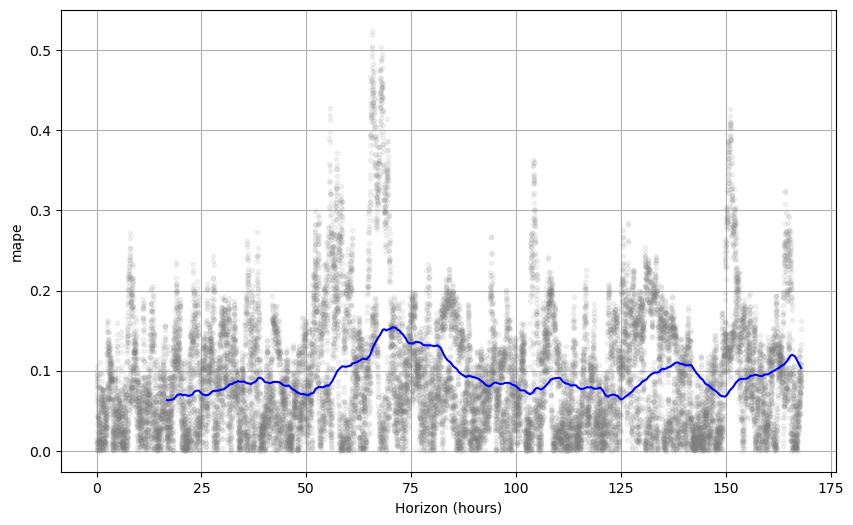

In [54]:
# plot the mean absolute percent error (mape)

from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

StatementMeta(, , , Waiting, )

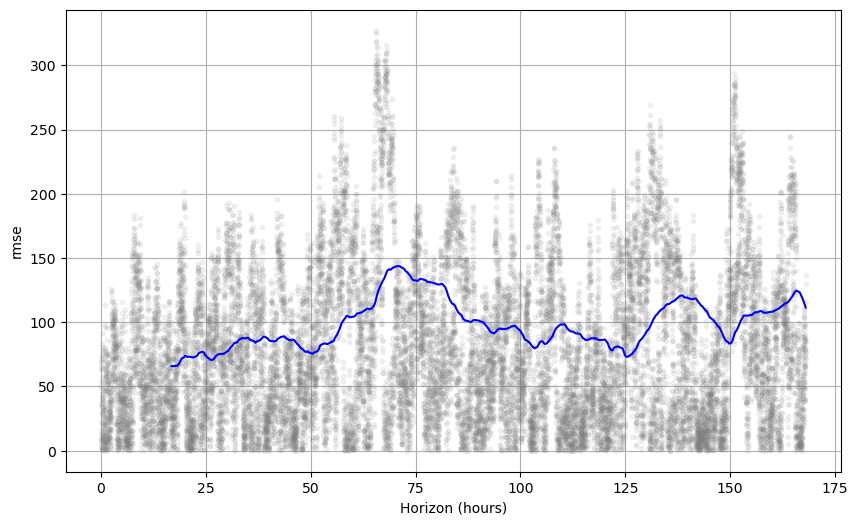

In [55]:
# plot the standard deviation or root mean square deviation (rmse)

from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')

In [56]:
# routine for testing multiple combinations of parameters

# by default we won't run this, but this is a way we can test multiple
# parameters and find the most optimal results

# more info at:
# https://facebook.github.io/prophet/docs/diagnostics.html

import itertools
import numpy as np
import pandas as pd

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0, 15],
    'weekly_seasonality': [3, 5]
}

def test_params():
    daysToValidate = numDays - 7

    # generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    rmses = []  # score the RMSEs for each params here

    # use cross validation to evaluate all parameters
    for params in all_params:
        
        m = Prophet(**params).fit(dfstocks_pd)  # fit model with given params
        df_cv = cross_validation(m, initial=f"{daysToValidate} days", period="7 days", horizon="7 days")
        df_p = performance_metrics(df_cv, rolling_window=1)
        rmses.append(df_p['rmse'].values[0])

    # Find the best parameters
    tuning_results = pd.DataFrame(all_params)
    tuning_results['rmse'] = rmses
    print(tuning_results)

# test_params()

StatementMeta(, , , Waiting, )

## Step 5: Log and load model with MLflow

MLflow assists with managing ML workflows. We can create a new experiment for each stock (as an example) and then add each run to the experiment. We can also log all of the parameters and metrics with each run, allowing us to see and compare different models. This is part of our operationalizing process. When the run is logged in the experiment, the run is given a URI that can be used to load the model later; however, it's also possible to interact with MLflow visually or programmatically to load/inspect models.

In [57]:
# setup mlflow with an experiment

import mlflow

EXPERIMENT_NAME = f"{STOCK_SYMBOL}-stock-prediction"
mlflow.set_experiment(EXPERIMENT_NAME)


StatementMeta(, , , Waiting, )

2024/03/20 00:08:41 INFO mlflow.tracking.fluent: Experiment with name 'CSCO-stock-prediction' does not exist. Creating a new experiment.


<Experiment: artifact_location='', creation_time=1710893324157, experiment_id='250323dd-1d39-415b-85d0-3f19f6c8e68f', last_update_time=None, lifecycle_stage='active', name='CSCO-stock-prediction', tags={}>

In [58]:
from mlflow.models.signature import infer_signature

model_name = f"{EXPERIMENT_NAME}-model"
with mlflow.start_run() as run:
    mlflow.autolog()

    mlflow.prophet.log_model(m, model_name, registered_model_name=model_name,
        signature=infer_signature(future, forecast))

    mlflow.log_params({"changepoint_prior_scale": changepoint_prior_scale })
    mlflow.log_params({"changepoint_range": changepoint_range })
    mlflow.log_params({"seasonality_prior_scale": seasonality_prior_scale })
    mlflow.log_params({"weekly_seasonality": weekly_seasonality })

    mlflow.log_metrics({"mse":mse})
    mlflow.log_metrics({"mae":mae})
    mlflow.log_metrics({"rmse":rmse})
    mlflow.log_metrics({"mape":mape})

    model_uri = f"runs:/{run.info.run_id}/{model_name}"

    print("Model saved in run %s" % run.info.run_id)
    print(f"Model URI: {model_uri}")

StatementMeta(, , , Waiting, )

/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning:

Setuptools is replacing distutils.

Successfully registered model 'CSCO-stock-prediction-model'.
2024/03/20 00:08:53 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: CSCO-stock-prediction-model, version 1
Created version '1' of model 'CSCO-stock-prediction-model'.


Model saved in run a9c83850-d5d7-44e8-b801-4399b5318ea9
Model URI: runs:/a9c83850-d5d7-44e8-b801-4399b5318ea9/CSCO-stock-prediction-model


## Step 6: Load the model and generate predictions

In this step, we'll load the model from MLflow and create a new prediction for the next week. 

Because this is a simulation for demo purposes, we already have the future data (or at least, one possibility of future data as the algorithm is highly random). This allows us to compare what the model predicts vs actual. We'll combine the predicted dataset with the actual dataset, and plot the outcome to compare.

In [59]:
import mlflow

loaded_model = mlflow.prophet.load_model(model_uri)

StatementMeta(, , , Waiting, )

StatementMeta(, e58fbfc4-8412-4b0b-9b85-bdec62715a42, 71, Finished, Available)

In [69]:
# establish begin/end dates for prediction

import datetime
from datetime import timedelta

currentdate = datetime.datetime.utcnow()
currentdate = currentdate.replace(hour=0, minute=0, second=0, microsecond=0)
enddate = currentdate - datetime.timedelta(days=7)

print(f'Beginning of forecast: {enddate}')
print(f'End of forecast: {currentdate}')

StatementMeta(, e58fbfc4-8412-4b0b-9b85-bdec62715a42, 77, Finished, Available)

Beginning of forecast: 2024-03-13 00:00:00
End of forecast: 2024-03-20 00:00:00


In [72]:
# load all of the 'future' data -- 
# will be used to compare prediction

df_stocks_future = df_stocks.select("*").where(
    f'timestamp >= "{str(enddate)}" and timestamp < "{str(currentdate)}"')

df_stocks_future.tail(4)

StatementMeta(, e58fbfc4-8412-4b0b-9b85-bdec62715a42, 80, Finished, Available)

[Row(price=965.45, symbol='CSCO', timestamp='2024-03-19 23:56:00'),
 Row(price=959.3, symbol='CSCO', timestamp='2024-03-19 23:57:00'),
 Row(price=960.9, symbol='CSCO', timestamp='2024-03-19 23:58:00'),
 Row(price=978.75, symbol='CSCO', timestamp='2024-03-19 23:59:00')]

In [76]:
import pandas as pd

# create a new dataframe to hold the predictions
# copy the timestamp from the future dataframe for convenience
# this new dataframe should only have timestamps for our prediction, 
# and will be labelled as 'ds'

df_stocks_future_pd = df_stocks_future.toPandas()
dfstocks_predict = df_stocks_future_pd[['timestamp']].copy()

# rename timestamp to ds as expected by prophet
dfstocks_predict = dfstocks_predict.rename(columns={'timestamp': 'ds'})

print('Min: ', dfstocks_predict['ds'].min())
print('Max: ', dfstocks_predict['ds'].max())
dfstocks_predict.head()

StatementMeta(, e58fbfc4-8412-4b0b-9b85-bdec62715a42, 113, Finished, Available)

Min:  2024-03-13 00:00:00
Max:  2024-03-19 23:59:00


,ds
0,2024-03-13 00:00:00
1,2024-03-13 00:01:00
2,2024-03-13 00:02:00
3,2024-03-13 00:03:00
4,2024-03-13 00:04:00


In [77]:
# optionally, can use make_future_dataframe in Prophet to make a suitable df

test_df = loaded_model.make_future_dataframe(periods=60*24*7, freq='min', include_history = False)
test_df.head()

StatementMeta(, e58fbfc4-8412-4b0b-9b85-bdec62715a42, 114, Finished, Available)

,ds
0,2024-03-19 00:00:00
1,2024-03-19 00:01:00
2,2024-03-19 00:02:00
3,2024-03-19 00:03:00
4,2024-03-19 00:04:00


In [78]:
# predict by passing in the dataframe with timestamps to forecast

forecast = loaded_model.predict(dfstocks_predict)
forecast.head()

StatementMeta(, e58fbfc4-8412-4b0b-9b85-bdec62715a42, 115, Finished, Available)

ValueError: unconverted data remains when parsing with format "%Y-%m-%d %H:%M:%S": ".435887", at position 10041. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [ ]:
# Code generated by Data Wrangler for pandas DataFrame

def clean_data(dfstocks_predict):
    # Change column type to datetime64[ns] for column: 'ds'
    dfstocks_predict = dfstocks_predict.astype({'ds': 'datetime64[ns]'})
    return dfstocks_predict

dfstocks_predict_clean = clean_data(dfstocks_predict.copy())
dfstocks_predict_clean.head()

In [ ]:
# combine forecast and df_stocks_future_pd

df_stocks_future_pd['timestamp'] = pd.to_datetime(df_stocks_future_pd['timestamp'])
forecast['ds'] = pd.to_datetime(forecast['ds'])

metric_df = forecast.set_index('ds')[['yhat']].join(df_stocks_future_pd.set_index('timestamp').price).reset_index()
metric_df.head()

StatementMeta(, , , Waiting, )

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

metric_df['ds'] = pd.to_datetime(metric_df['ds'])

fig = go.Figure()
fig.add_trace(go.Scatter(x=metric_df['ds'], y=metric_df['price'], name='Actual', line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=metric_df['ds'], y=metric_df['yhat'], name='Predicted', line=dict(color='red', width=3)))

fig.update_layout(title="Predicted vs Actual", showlegend=True)
fig.show()

StatementMeta(, , , Waiting, )

In [ ]:
# optionally, compute metrics using sklearn to see how they compare to our model

from sklearn.metrics import mean_squared_error, mean_absolute_error

future_mse = round(mean_squared_error(metric_df.price, metric_df.yhat),3)
future_mae = round(mean_absolute_error(metric_df.price, metric_df.yhat),3)
future_rmse = round(mean_squared_error(metric_df.price, metric_df.yhat, squared=False),3)

print(f'mse: {future_mse} (Model: {mse})')
print(f'mae: {future_mae} (Model: {mae})')
print(f'rmse: {future_rmse} (Model: {rmse})')

StatementMeta(, , , Waiting, )

## Additional MLflow
MLflow can be interacted with programmatically to load and inspect models. The example below will show all experiments and runs within each experiment.

In [ ]:
import mlflow
import pandas as pd

experiments = mlflow.search_experiments()
for exp in experiments:
    print(f'{exp.name} ({exp.experiment_id})')
    runs_df = mlflow.search_runs(exp.experiment_id)
    display(runs_df)

StatementMeta(, , , Waiting, )